# Simple Linear Regression with OLS

## Imports and connection

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

## Understanding the Data

In [3]:
housing_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

## Missing Values

In [5]:
total_missing = housing_df.isnull().sum().sort_values(ascending=False)
percent_missing = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


These are all the missing values. For this exercise, I will avoid filling out missing values.

## EDA

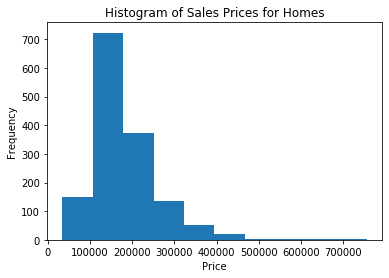

In [6]:
plt.hist(housing_df['saleprice'])
plt.title('Histogram of Sales Prices for Homes')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

For numeric data, we can look at correlations. For non-numeric data, we must look at bar plots of categorical variable vs. target variable.

In [7]:
numeric_columns = housing_df.select_dtypes(['int64', 'float64']).columns

print(len(numeric_columns))
print(numeric_columns)

38
Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')


In [8]:
X = housing_df.iloc[:,1:].values

print(housing_df.shape)
print(X.shape)

(1460, 81)
(1460, 80)


In [9]:
np.abs(housing_df[numeric_columns].iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

In [10]:
non_numeric_data = housing_df.select_dtypes(['object']).columns

print(len(non_numeric_data))
print(non_numeric_data)

43
Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')


In [11]:
for index, column in enumerate(non_numeric_data):
    print(index, column)

0 mszoning
1 street
2 alley
3 lotshape
4 landcontour
5 utilities
6 lotconfig
7 landslope
8 neighborhood
9 condition1
10 condition2
11 bldgtype
12 housestyle
13 roofstyle
14 roofmatl
15 exterior1st
16 exterior2nd
17 masvnrtype
18 exterqual
19 extercond
20 foundation
21 bsmtqual
22 bsmtcond
23 bsmtexposure
24 bsmtfintype1
25 bsmtfintype2
26 heating
27 heatingqc
28 centralair
29 electrical
30 kitchenqual
31 functional
32 fireplacequ
33 garagetype
34 garagefinish
35 garagequal
36 garagecond
37 paveddrive
38 poolqc
39 fence
40 miscfeature
41 saletype
42 salecondition


In [12]:
print(housing_df.groupby('saletype')['saleprice'].mean())

saletype
COD      143973.255814
CWD      210600.000000
Con      269600.000000
ConLD    138780.888889
ConLI    200390.000000
ConLw    143700.000000
New      274945.418033
Oth      119850.000000
WD       173401.836622
Name: saleprice, dtype: float64


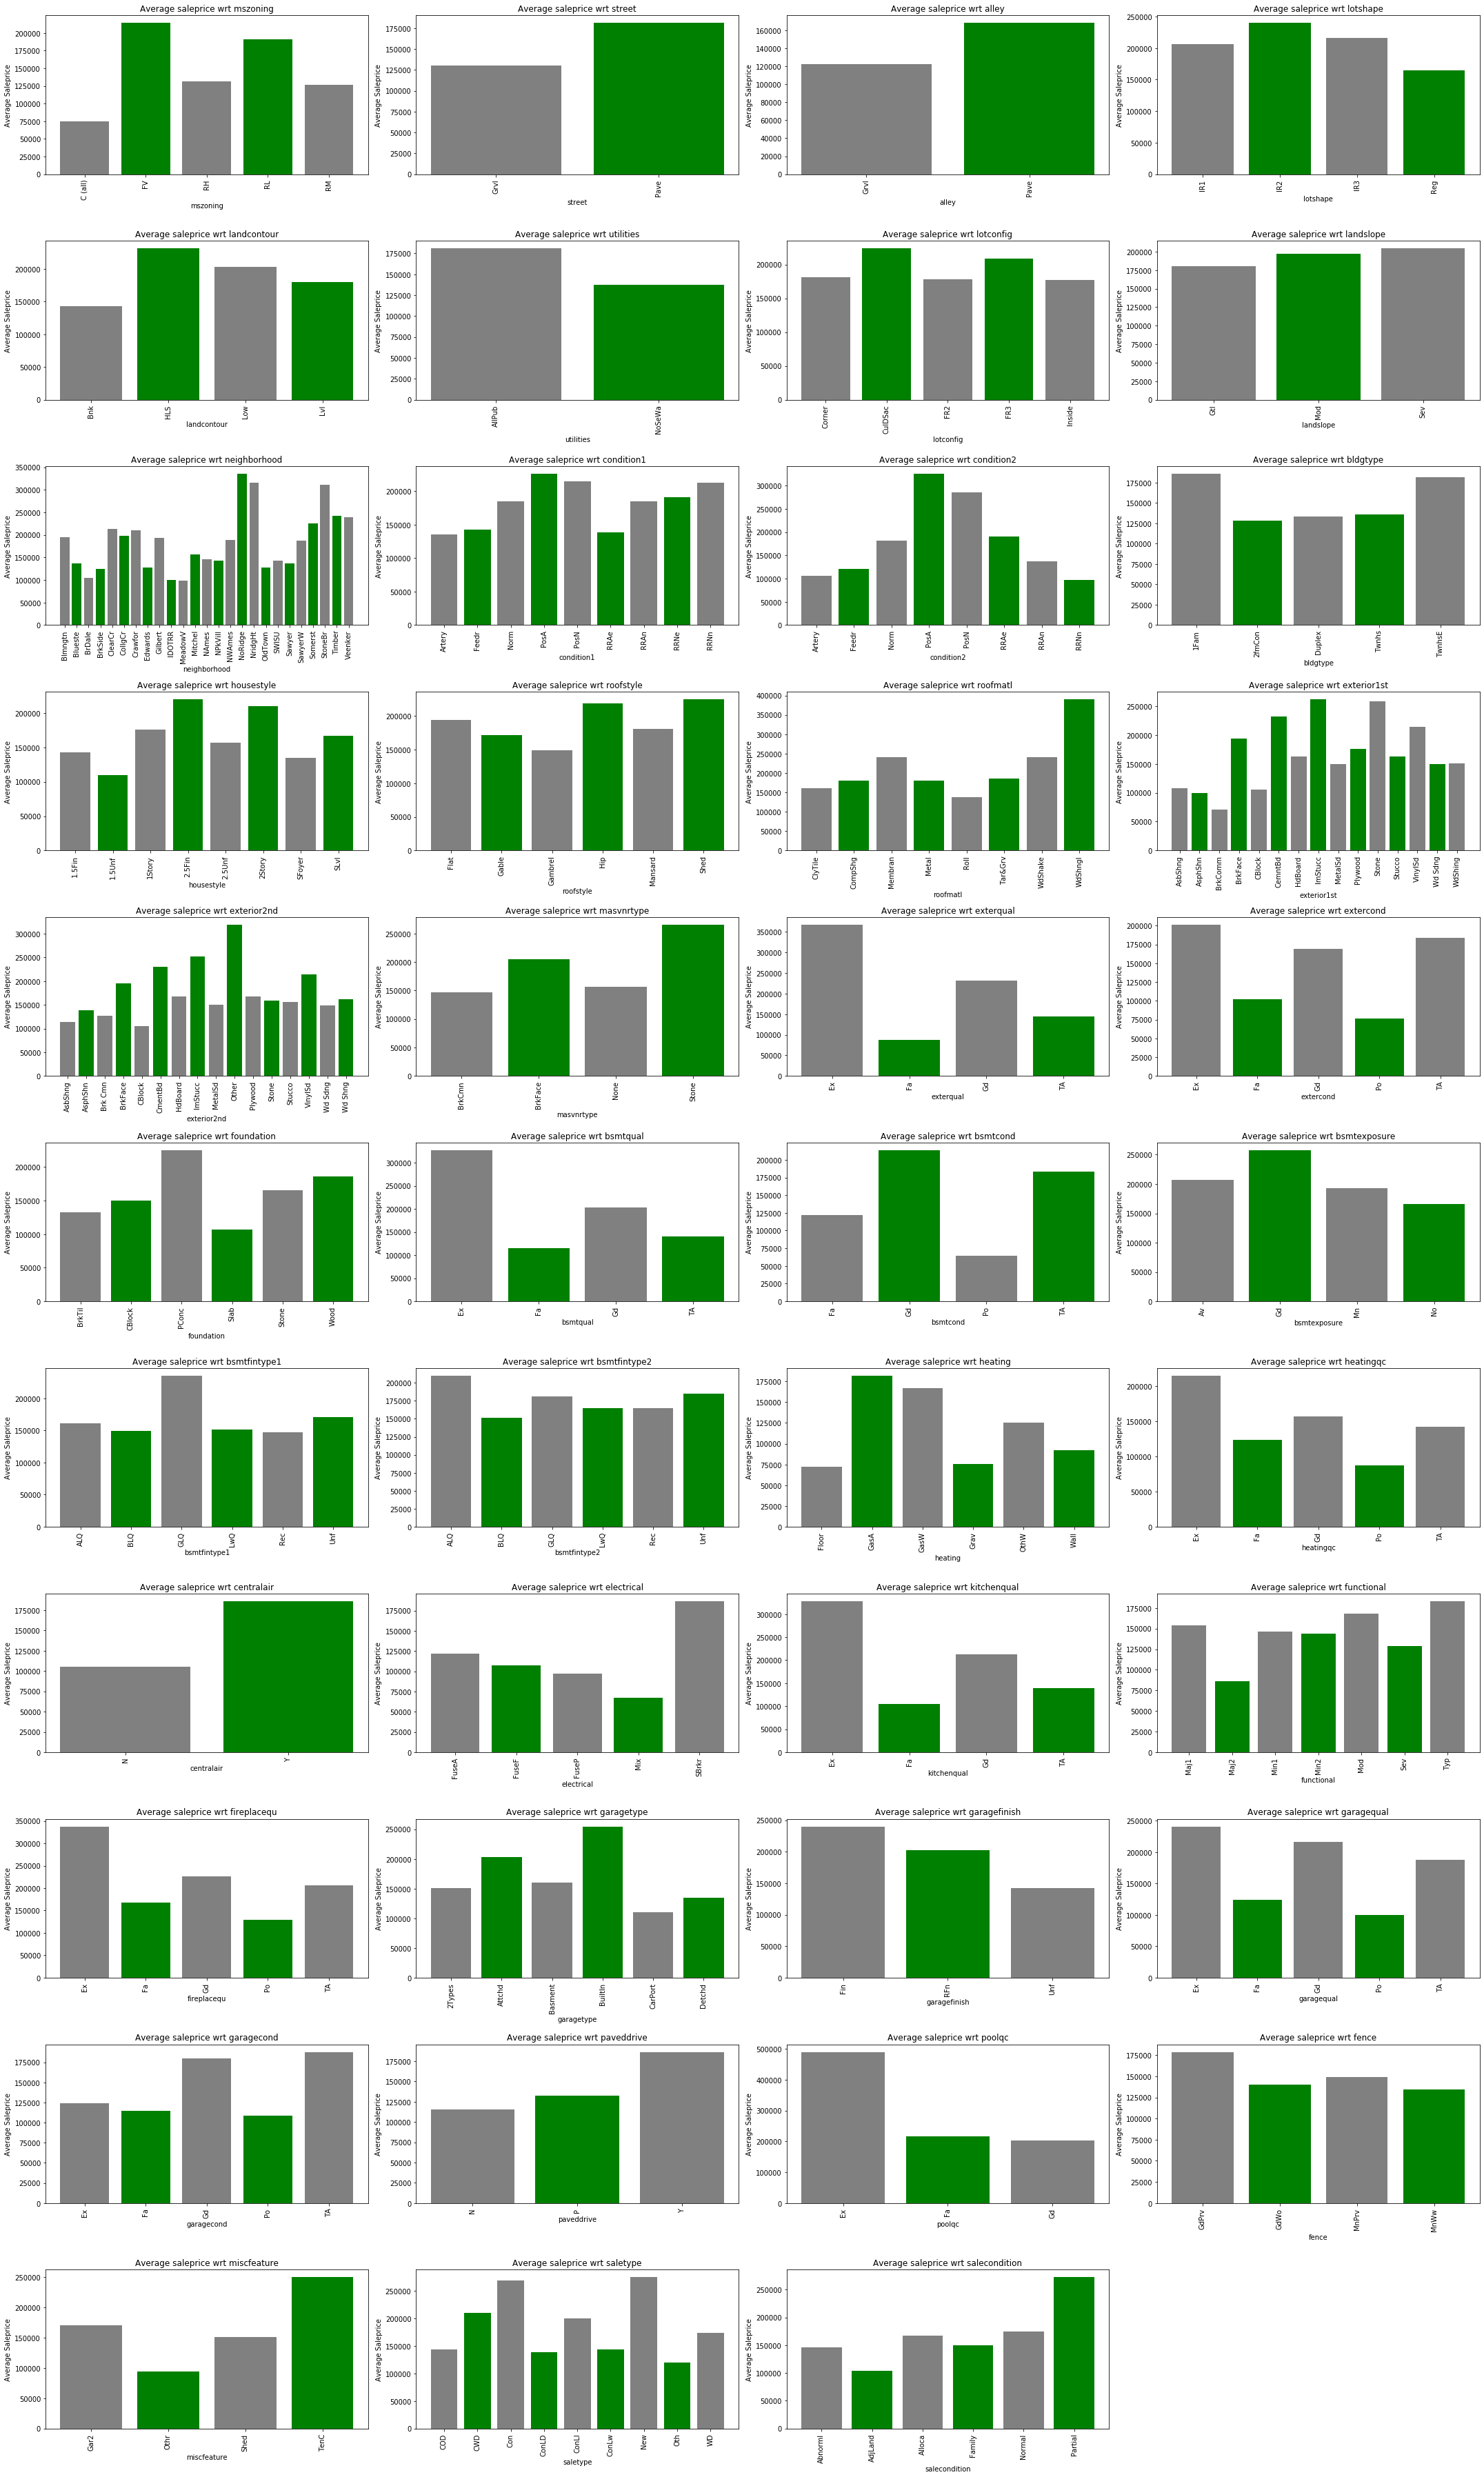

In [13]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_data):
    plt.subplot(11,4,index+1)
    plt.bar(housing_df.groupby(column)['saleprice'].mean().index,
           housing_df.groupby(column)['saleprice'].mean(), color=('grey', 'green'))
    plt.title('Average saleprice wrt {}'.format(column))
    plt.xlabel(column)
    plt.ylabel('Average Saleprice')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

I will choose 6 numerical variables for my model, along with 2 non-numerical variables which exhibit strong effects on saleprice: mszoning and alley. To use these latter variables in our model, we will convert them to dummy variables.

In [14]:
housing_df = pd.concat([housing_df,
                        pd.get_dummies(
                            housing_df.mszoning,
                            prefix='mszoning',
                            drop_first=True)],
                            axis=1)

housing_df = pd.concat([housing_df,
                        pd.get_dummies(
                        housing_df.alley,
                        prefix='alley',
                        drop_first=True)],
                        axis=1)

In [15]:
zoning = pd.get_dummies(housing_df.mszoning, prefix="mszoning", drop_first=True).columns.tolist()

alley = pd.get_dummies(housing_df.alley, prefix="alley", drop_first=True).columns.tolist()

print(zoning)
print(alley)

['mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM']
['alley_Pave']


In [16]:
housing_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,mosold,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,alley_Pave
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,2,2008,WD,Normal,208500,0,0,1,0,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,5,2007,WD,Normal,181500,0,0,1,0,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,9,2008,WD,Normal,223500,0,0,1,0,0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,2,2006,WD,Abnorml,140000,0,0,1,0,0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,12,2008,WD,Normal,250000,0,0,1,0,0


### Regression Model

In [17]:
X = housing_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf'] + zoning + alley]
y = housing_df.saleprice

In [18]:
import statsmodels.api as sm

In [19]:
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     441.0
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        22:27:22   Log-Likelihood:                -17471.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1448   BIC:                         3.503e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.15e+05   1.26e+04     -9.115      0.000    -1.4e+05   -9.02e+04
overallqual   2.35e+04   1094.263     21.476      0.000    2.14e+04    2.56e+04
grlivarea      44.5503      2.650     16.814      0.000      39.353      49.748
garagecars   1.379e+04   2985.702      4.617      0.000    7928.608    1.96e+04
garagearea     13.5371     10.414      1.300      0.194      -6.892      33.966
totalbsmtsf    24.1848      4.254      5.685      0.000      15.840      32.529
firstflrsf      6.8161      5.041      1.352      0.177      -3.072      16.704
mszoning_FV  2.797e+04   1.33e+04      2.098      0.036    1813.156    5.41e+04
mszoning_RH  1.115e+04   1.55e+04      0.718      0.473   -1.93e+04    4.16e+04
mszoning_RL  2.419e+04   1.24e+04      1.951      0.051    -132.966    4.85e+04
mszoning_RM  5529.2874   1.26e+04      0.440      0.660   -1.91e+04    3.02e+04
alley_Pave  -1.697e+04   6866.283     -2.472      0.014   -3.04e+04   -3502.015
==============================================================================
Omnibus:                      414.854   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40889.556
Skew:                          -0.109   Prob(JB):                         0.00
Kurtosis:                      28.925   Cond. No.                     6.47e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""